In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import pytorch_lightning as pl

import torch
from torch import optim

from bliss.models import encoder, decoder, flux_net
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import plotting_utils 

device = "cuda:4"
print(device)

pl.seed_everything(2323)

Global seed set to 2323


cuda:4


2323

# Load dataset

In [2]:
overrides = {'model':'sleep_star_one_tile', 'dataset': "single_tile"}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
cfg.model.kwargs.decoder_kwargs.update({'prob_galaxy': 0., 
                                        'tile_slen': 4,
                                        'ptile_slen': 20,
                                        'f_min':1e4,
                                        'f_max': 1e5, 
                                        'max_sources': 1, 
                                        'min_sources': 1})

In [4]:
cfg.model.image.update({
    'slen': 4
})

In [5]:
cfg.optimizer.kwargs.update({'lr': 0.001})

In [6]:
# set device
cfg.dataset.kwargs.update({'generate_device': device})

In [7]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

In [8]:
cfg.training.n_epochs

121

### some sample images

In [9]:
test_dataloader = dataset.test_dataloader()

In [10]:
for _, batch in enumerate(test_dataloader):
    break

In [11]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [12]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [13]:
%matplotlib inline

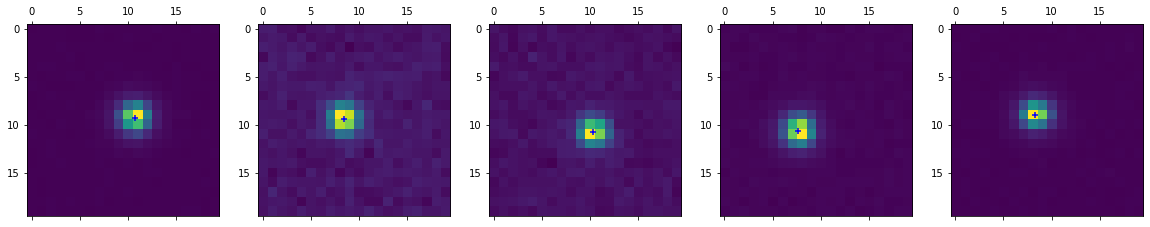

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

(array([2569., 1226.,  707.,  486.,  379.,  289.,  220.,  197.,  178.,
         149.]),
 array([10002.55 , 18999.18 , 27995.81 , 36992.44 , 45989.07 , 54985.7  ,
        63982.332, 72978.96 , 81975.59 , 90972.22 , 99968.85 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

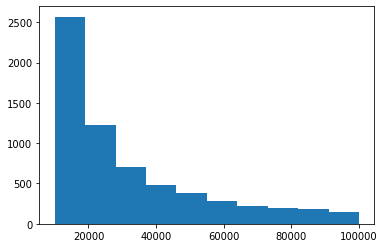

In [15]:
f = batch['fluxes'].flatten()
f = f[f > 0]

plt.hist(f.cpu().numpy())

# Define encoder

In [16]:
flux_estimator = flux_net.FluxEstimator(cfg.model.kwargs.decoder_kwargs, 
                                        optimizer_params=cfg.optimizer)
flux_estimator.to(device);

conv_out_dim 16


In [17]:
flux_estimator.enc

FluxEncoderNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Initial loss

In [18]:
def eval_loss(): 
    loss = 0
    counter = 0
    target = 0

    for _, batch in enumerate(test_dataloader):
        
        # estimated loss
        loss += flux_estimator.get_loss(batch)

        # loss under the truth
        target += flux_estimator.kl_qp_flux_loss( 
                        batch,
                        batch['fluxes'], 
                        # set the sd to 1
                        batch['fluxes'] * 0. + 1.0)[0].mean()

        counter += 1
        
        break

    print('loss: {}'.format(loss / counter))
    print('target: {}'.format(target / counter))

In [19]:
eval_loss()

tensor(0.0128, device='cuda:4', grad_fn=<MinBackward1>)
loss: 79421.9453125
target: 1869.6396484375


# Optimize

In [20]:
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [21]:
t0 = time.time()
trainer.fit(flux_estimator, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type           | Params
-------------------------------------------------
0 | image_decoder | ImageDecoder   | 6     
1 | enc           | FluxEncoderNet | 12.8 K
-------------------------------------------------
12.8 K    Trainable params
6         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

tensor(0.0218, device='cuda:0')


Global seed set to 2323


tensor(0.0236, device='cuda:0')


Training: 0it [00:00, ?it/s]

tensor(0.0151, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0098, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0057, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0036, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0021, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.9200, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0439, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0992, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3079, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.9477, device='cuda:0', grad_fn=<MinB

Validating: 0it [00:00, ?it/s]

tensor(175.6228, device='cuda:0')
tensor(174.3084, device='cuda:0')
tensor(175.7973, device='cuda:0')
tensor(174.6972, device='cuda:0')
tensor(174.5785, device='cuda:0')
tensor(174.8455, device='cuda:0')
tensor(176.7467, device='cuda:0')
tensor(175.1683, device='cuda:0')
tensor(175.9462, device='cuda:0')
tensor(175.7257, device='cuda:0')
tensor(176.1648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(167.2296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(169.3214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(155.2276, device='cuda:0', grad_fn=<MinBackward1>)
tensor(153.6990, device='cuda:0', grad_fn=<MinBackward1>)
tensor(145.6669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(165.0628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(189.8674, device='cuda:0', grad_fn=<MinBackward1>)
tensor(209.4801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(235.5496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(246.6767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(266.7693, devic

Validating: 0it [00:00, ?it/s]

tensor(119.1016, device='cuda:0')
tensor(117.5137, device='cuda:0')
tensor(117.2473, device='cuda:0')
tensor(117.6985, device='cuda:0')
tensor(118.9602, device='cuda:0')
tensor(117.8924, device='cuda:0')
tensor(117.4274, device='cuda:0')
tensor(118.5325, device='cuda:0')
tensor(118.7563, device='cuda:0')
tensor(117.3286, device='cuda:0')
tensor(118.3215, device='cuda:0', grad_fn=<MinBackward1>)
tensor(136.6193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(154.5140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(168.0843, device='cuda:0', grad_fn=<MinBackward1>)
tensor(182.1354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(192.8216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(185.9220, device='cuda:0', grad_fn=<MinBackward1>)
tensor(173.1022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(155.2952, device='cuda:0', grad_fn=<MinBackward1>)
tensor(140.3676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(123.4713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(108.5463, devic

Validating: 0it [00:00, ?it/s]

tensor(113.7672, device='cuda:0')
tensor(115.3799, device='cuda:0')
tensor(115.5886, device='cuda:0')
tensor(115.0690, device='cuda:0')
tensor(117.1961, device='cuda:0')
tensor(115.3400, device='cuda:0')
tensor(116.5681, device='cuda:0')
tensor(116.0636, device='cuda:0')
tensor(116.0623, device='cuda:0')
tensor(115.5921, device='cuda:0')
tensor(115.3919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(111.0718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(102.3798, device='cuda:0', grad_fn=<MinBackward1>)
tensor(93.4917, device='cuda:0', grad_fn=<MinBackward1>)
tensor(91.2802, device='cuda:0', grad_fn=<MinBackward1>)
tensor(89.8787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(96.1067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(99.5850, device='cuda:0', grad_fn=<MinBackward1>)
tensor(114.3389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(123.6712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(126.4410, device='cuda:0', grad_fn=<MinBackward1>)
tensor(122.8171, device='cu

Validating: 0it [00:00, ?it/s]

tensor(143.8930, device='cuda:0')
tensor(147.7810, device='cuda:0')
tensor(147.0604, device='cuda:0')
tensor(146.8355, device='cuda:0')
tensor(147.4158, device='cuda:0')
tensor(147.2305, device='cuda:0')
tensor(147.3929, device='cuda:0')
tensor(147.3863, device='cuda:0')
tensor(148.3479, device='cuda:0')
tensor(147.5230, device='cuda:0')
tensor(144.7867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(153.2861, device='cuda:0', grad_fn=<MinBackward1>)
tensor(159.1126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(158.1739, device='cuda:0', grad_fn=<MinBackward1>)
tensor(158.3145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(157.5848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(153.0545, device='cuda:0', grad_fn=<MinBackward1>)
tensor(145.4235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(137.2584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(129.6022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(140.5135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(149.8448, devic

Validating: 0it [00:00, ?it/s]

tensor(144.5705, device='cuda:0')
tensor(145.0836, device='cuda:0')
tensor(143.4001, device='cuda:0')
tensor(145.0387, device='cuda:0')
tensor(144.4101, device='cuda:0')
tensor(144.4506, device='cuda:0')
tensor(143.7062, device='cuda:0')
tensor(144.2261, device='cuda:0')
tensor(144.2639, device='cuda:0')
tensor(145.1482, device='cuda:0')
tensor(144.3161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(146.0916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(148.4827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(150.1722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(155.7465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(156.6728, device='cuda:0', grad_fn=<MinBackward1>)
tensor(155.1765, device='cuda:0', grad_fn=<MinBackward1>)
tensor(151.0510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(144.2167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(139.3970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(138.8390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(145.0822, devic

Validating: 0it [00:00, ?it/s]

tensor(139.5281, device='cuda:0')
tensor(136.5569, device='cuda:0')
tensor(136.7968, device='cuda:0')
tensor(139.1081, device='cuda:0')
tensor(141.0597, device='cuda:0')
tensor(140.1658, device='cuda:0')
tensor(140.1764, device='cuda:0')
tensor(138.3499, device='cuda:0')
tensor(140.6604, device='cuda:0')
tensor(137.9517, device='cuda:0')
tensor(140.5126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(158.8121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(165.4417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(162.5759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(146.3605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(135.1067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(134.3426, device='cuda:0', grad_fn=<MinBackward1>)
tensor(140.4393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(154.1657, device='cuda:0', grad_fn=<MinBackward1>)
tensor(158.0018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(159.1699, device='cuda:0', grad_fn=<MinBackward1>)
tensor(154.2006, devic

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


# Evaluate

In [22]:
flux_estimator.to(device);

In [23]:
for _, test_batch in enumerate(test_dataloader):
    break

In [24]:
# get estimates
out = flux_estimator(test_batch['images'])

# get loss
_, recon = flux_estimator.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'])

tensor(147.7626, device='cuda:4', grad_fn=<MinBackward1>)


In [25]:
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


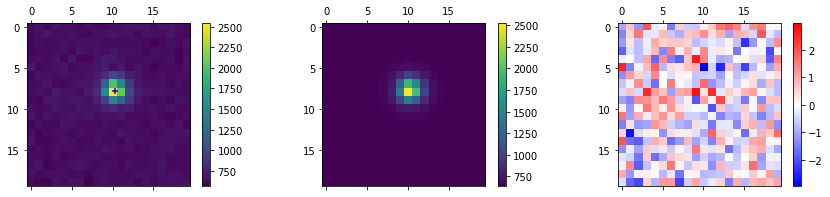

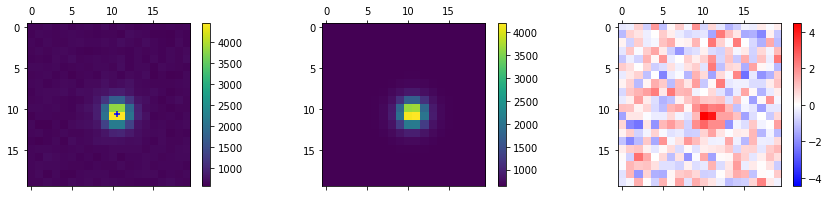

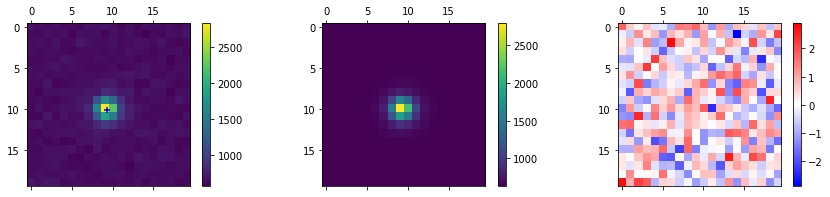

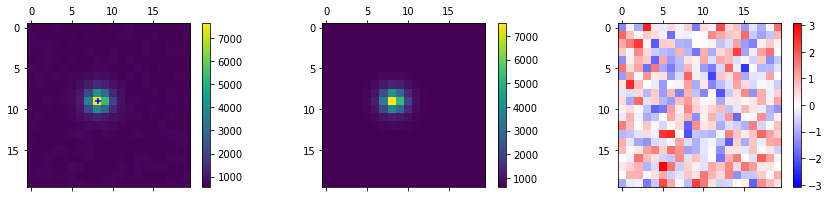

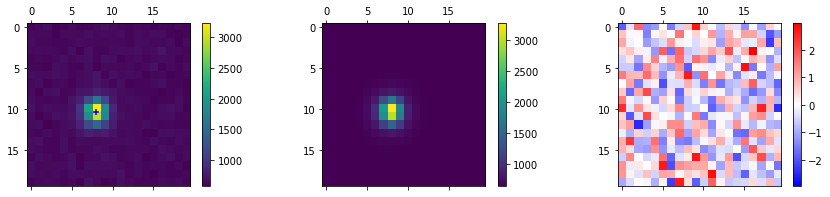

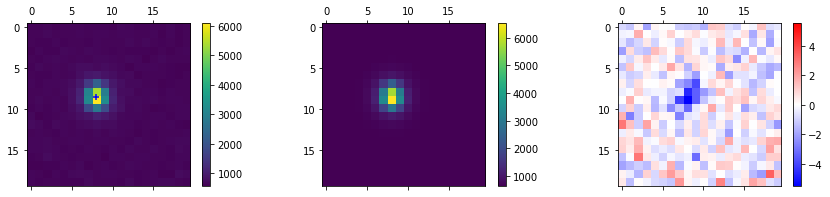

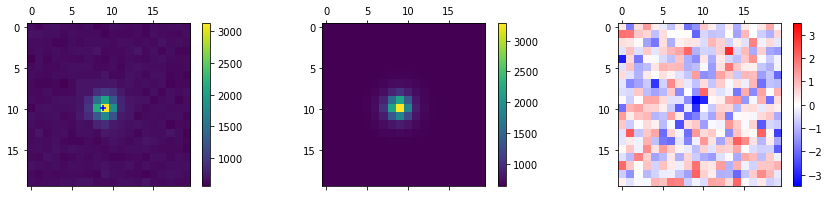

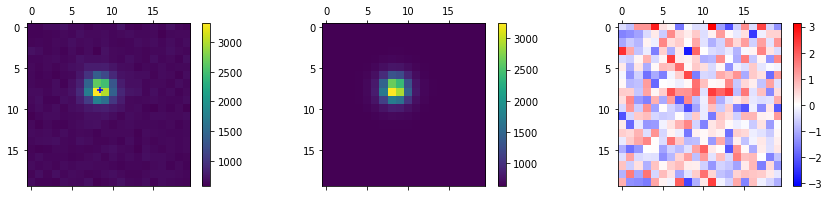

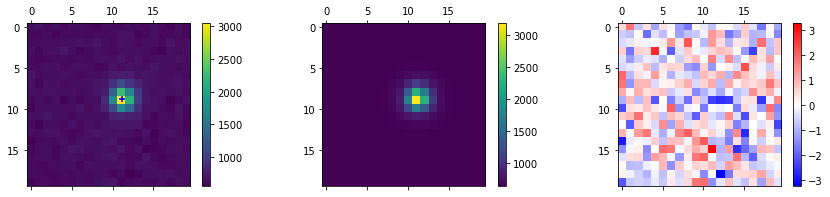

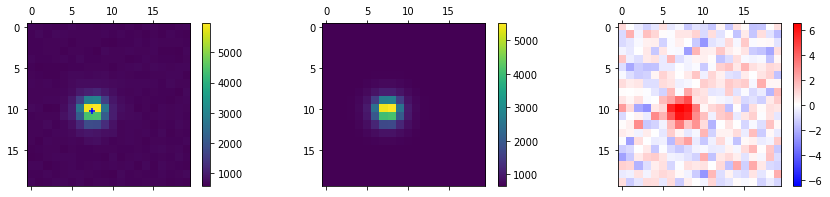

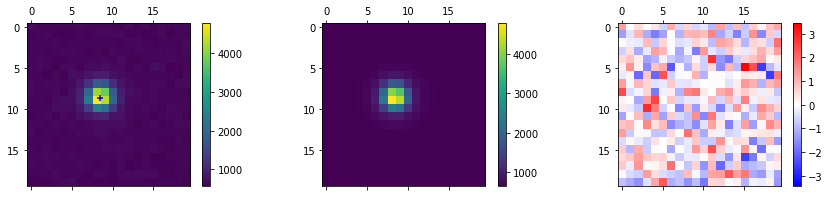

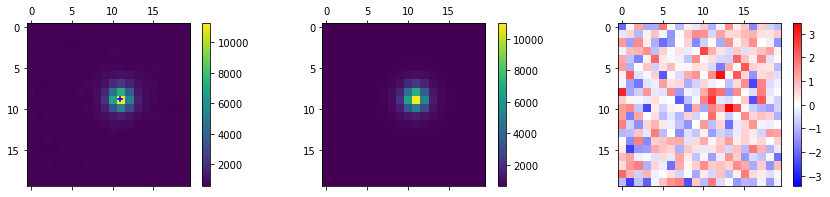

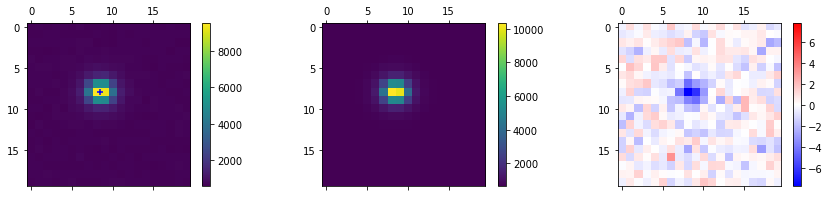

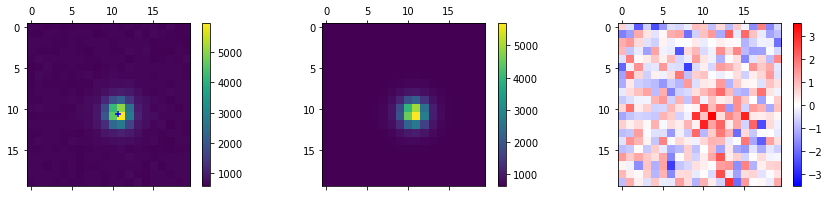

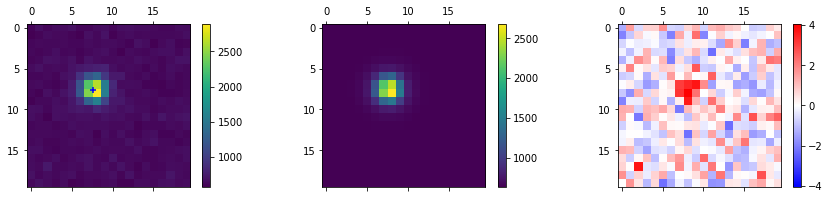

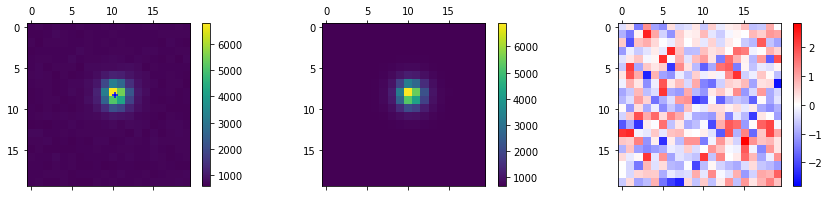

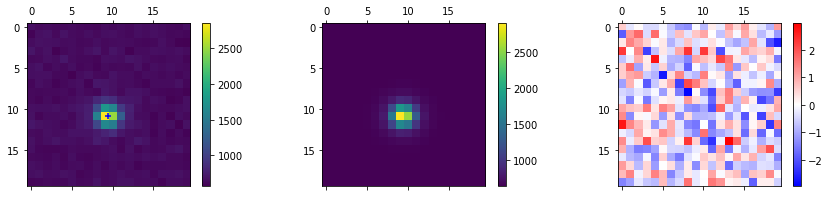

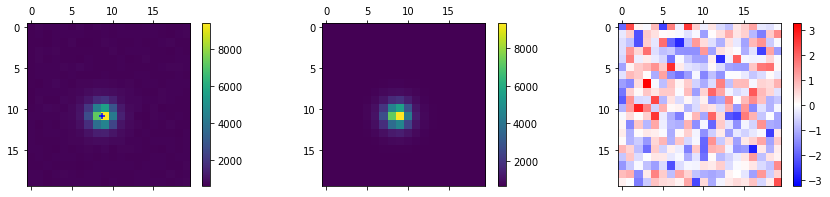

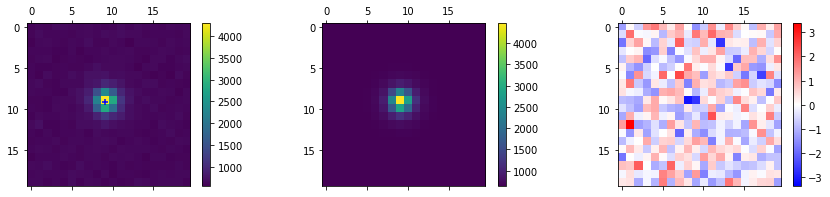

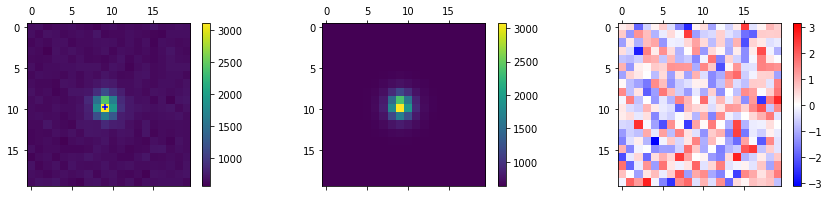

In [26]:
for indx in range(20):

    fig, ax = plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                            recon[indx, 0], 
                                            resid_fun=lambda x, y : (x - y) / torch.sqrt(y))
    
    # plot parameters
    plot_params(true_params, indx, ax[0])

### Compare fluxes

In [27]:
truth = []
est = []
sd = []

for _, batch in enumerate(test_dataloader):
    
    # get estimates
    out = flux_estimator(batch['images'])
    
    is_star = get_star_bool(batch['n_sources'], batch['galaxy_bool']) == 1

    _truth = batch['fluxes'][is_star].cpu().numpy()
    _est = out['mean'][is_star].cpu().detach().numpy()
    _sd = out['sd'][is_star].cpu().detach().numpy()
    
    truth.append(_truth)
    est.append(_est)
    sd.append(_sd)
    
truth = np.concatenate(truth)
est = np.concatenate(est)
sd = np.concatenate(sd)

tensor(144.6288, device='cuda:4', grad_fn=<MinBackward1>)
tensor(148.3576, device='cuda:4', grad_fn=<MinBackward1>)
tensor(145.1546, device='cuda:4', grad_fn=<MinBackward1>)
tensor(147.7569, device='cuda:4', grad_fn=<MinBackward1>)
tensor(146.6948, device='cuda:4', grad_fn=<MinBackward1>)
tensor(146.5773, device='cuda:4', grad_fn=<MinBackward1>)
tensor(143.8661, device='cuda:4', grad_fn=<MinBackward1>)
tensor(145.9961, device='cuda:4', grad_fn=<MinBackward1>)
tensor(146.9012, device='cuda:4', grad_fn=<MinBackward1>)
tensor(146.6169, device='cuda:4', grad_fn=<MinBackward1>)


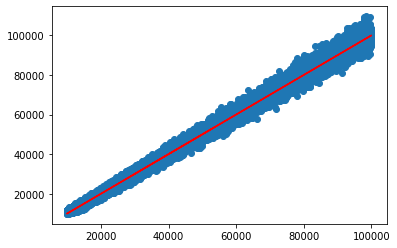

In [28]:
plt.scatter(truth, est)

plt.plot(truth, truth, color = 'red')

In [29]:
sd

array([271.78125, 170.94576, 157.17958, ..., 381.241  , 363.7349 ,
       178.48247], dtype=float32)

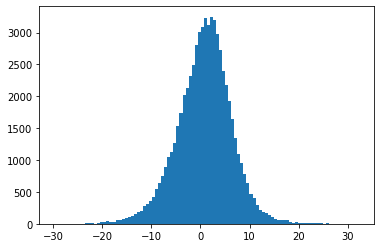

In [30]:
zscore = (est - truth) / sd

plt.hist(zscore, bins = 100);

(array([22466., 16676.,  8636.,  5761.,  3997.,  2883.,  1951.,  1201.,
          395.,    34.]),
 array([143.86607, 173.96645, 204.06683, 234.1672 , 264.26758, 294.36795,
        324.46832, 354.56873, 384.6691 , 414.76947, 444.86984],
       dtype=float32),
 <BarContainer object of 10 artists>)

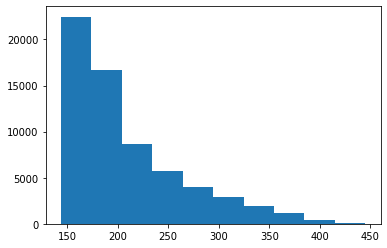

In [31]:
plt.hist(sd)

In [32]:
# trainer.save_checkpoint('../../models/flux_net.ckpt')